# Modelo de reacción-difusión de Gray-Scott

El sistema Gray-Scott modela la siguiente reacción química:

$$
U + 2V \rightarrow 3V 
$$
$$
V \rightarrow P
$$

Donde $U$, $V$ y $P$ son especies químicas genéricas. Este sistema simula cómo estas sustancias reaccionan entre sí y se difunden a través de un medio. En el caso de la reacción Gray-Scott la sustancia $U$ se agota, mientras la sustancia $V$ se produce.
El comportamiento general del sistema se describe mediante las siguientes ecuaciones, que representan factores de aumento o disminución en la concentración de cada una de las sustancias:

$$
\begin{array}{l}
\displaystyle u' = \frac{\partial u}{\partial t} = D_u \nabla^2 u - uv^2 + F(1-u) \\
\displaystyle v' = \frac{\partial v}{\partial t} = D_v \nabla^2 v + uv^2 - (F+k)v
\end{array}
$$

### Donde:

- $D_u \nabla^2 u \text{ y } D_v \nabla^2 v$ representan la **Difusión**: 
   - Este término representa el **movimiento o difusión** de las sustancias $U$ y $V$ hacia sus celdas vecinas.
   - $\nabla^2$ es el operador Laplaciano, que calcula la diferencia entre el valor promedio de las celdas vecinas y la celda actual.
   - Esta simulación de difusión permite que $U$ y $V$ se extiendan por el medio, causando que sus concentraciones se parezcan más a las de sus vecinos cercanos. Esto es finalmente lo que ayuda a formar patrones en el sistema.

- $-uv^2 \text{ en } U \text{ y } +uv^2 \text{ en } V$ representa la **Reacción**: 
   - Describe la **reacción química** entre $U$ y $V$.
   - Una molécula de $U$ y dos de $V$ se combinan para convertir $U$ en $V$. 
   - $U$ pierde concentración a un ritmo de $-uv^2$, 
   - $V$ gana concentración a un ritmo de $+uv^2$.

- $f(1 - u)$ representa la **entrada constante** de $U$ a la celda
   -  asegurando que siempre haya suministro de $U$ para la reacción.
   - El factor $f$ controla la tasa de alimentación de $U$, mientras que $(1 - u)$ asegura que $U$ no exceda un límite máximo de 1.0, lo cual mantiene el sistema en un rango estable.

- $-(k + f) B$ controla la **reducción de $V$**,
   - eliminando concentración de manera constante para que $V$ no se acumule indefinidamente.
   - Al restar una cantidad proporcional a $(k + f) V$, se asegura que $V$ se mantenga en equilibrio con $U$, evitando que el sistema colapse en un estado con exceso de $V$.

- $\Delta t$ representa el paso del tiempo


# Inicialización

Inicialmente $v$ es 0 y $u$ es 1 en todo el dominio, excepto en el centro, donde $ u = 0.5 $ y $v = 0.25$. A partir de esta zona es donde se empezarán a generar los patrones en la simulación

In [1]:
import numpy as np

In [2]:
def init(n):
    u = np.ones((n + 2, n + 2))
    v = np.zeros((n + 2, n + 2))

    x, y = np.meshgrid(np.linspace(0, 1, n + 2), np.linspace(0, 1, n + 2))

    mask = (0.4 < x) & (x < 0.6) & (0.4 < y) & (y < 0.6)

    u[mask] = 0.50
    v[mask] = 0.25

    return u, v

# Condición de frontera

Para esta simulación, asumiremos que la frontera es periódica

In [3]:
def periodic_bc(u):
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]

# Laplaciano Discreto

Utilizaremos la fórmula del Laplaciano Discreto en una celda $(i,j)$, definido como:

$$
\nabla^2 u_{i,j} \approx u_{i,j-1} + u_{i-1,j} - 4u_{i,j} + u_{i+1,j} + u_{i,j+1}
$$

In [4]:
def laplacian(u):
    return u[:-2, 1:-1] + u[1:-1, :-2] - 4 * u[1:-1, 1:-1] + u[1:-1, 2:] + +u[2:, 1:-1]

# Modelo Gray-Scott

In [5]:
def numpy_grayscott(U, V, Du, Dv, F, k):
    
    u, v = U[1:-1,1:-1], V[1:-1,1:-1]

    Lu = laplacian(U)
    Lv = laplacian(V)

    uvv = u*v*v
    u += Du*Lu - uvv + F*(1 - u)
    v += Dv*Lv + uvv - (F + k)*v

    periodic_bc(U)
    periodic_bc(V)
    
    return U, V

# Simulación

In [48]:
from tqdm.notebook import tqdm
from PIL import Image
from ipywidgets import interact, IntSlider

def create_image(grayscott, U, V, Du, Dv, F, k):
    for t in range(40):
        U, V = grayscott(U, V, Du, Dv, F, k) # create the model with the given parameters
    V_scaled = np.uint8(255*(V-V.min()) / (V.max()-V.min()))
    return V_scaled

def create_frames(n, grayscott, Du, Dv, F, k):
    U, V = init(300)
    return [create_image(grayscott, U, V, Du, Dv, F, k) for i in tqdm(range(n))]

# Visualización

In [51]:
def display_frames(frames):
    display(Image.fromarray(frames[-1]))

    def display_sequence(iframe):
        return Image.fromarray(frames[iframe])
    
    interact(display_sequence, 
             iframe=IntSlider(min=0,
                              max=len(frames)-1,
                              step=1,
                              value=0,
                              continuous_update=True))


  0%|          | 0/500 [00:00<?, ?it/s]

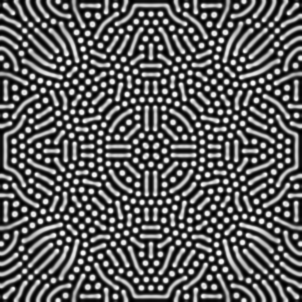

interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

In [50]:
Du, Dv = .1, .05
F, k = 0.03, 0.06
frames = create_frames(500, numpy_grayscott, Du, Dv, F, k)
display_frames(frames)

# Otros resultados interesantes

  0%|          | 0/500 [00:00<?, ?it/s]

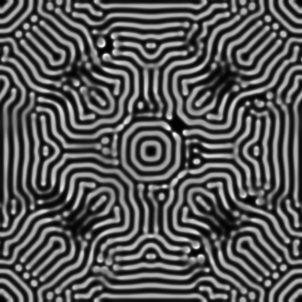

interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

In [54]:
Du, Dv = .1, .05
F, k = 0.024, 0.055
frames = create_frames(500, numpy_grayscott, Du, Dv, F, k)
display_frames(frames)

  0%|          | 0/500 [00:00<?, ?it/s]

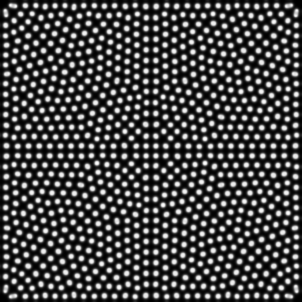

interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

In [55]:
Du, Dv = .1, .05
F, k = 0.028, 0.062
frames = create_frames(500, numpy_grayscott, Du, Dv, F, k)
display_frames(frames)

  0%|          | 0/500 [00:00<?, ?it/s]

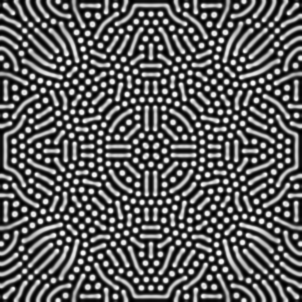

interactive(children=(IntSlider(value=0, description='iframe', max=499), Output()), _dom_classes=('widget-inte…

In [56]:
Du, Dv = .1, .05
F, k = 0.03, 0.06
frames = create_frames(500, numpy_grayscott, Du, Dv, F, k)
display_frames(frames)

# Fuentes

- https://www.karlsims.com/rd.html
- https://groups.csail.mit.edu/mac/projects/amorphous/GrayScott/
- https://itp.uni-frankfurt.de/~gros/StudentProjects/Projects_2020/projekt_schulz_kaefer/
- https://pnavaro.github.io/python-fortran/06.gray-scott-model.html
- https://en.wikipedia.org/wiki/Discrete_Laplace_operator#Implementation_via_operator_discretization
- https://github.com/benmaier/reaction-diffusion/blob/master/gray_scott.ipynb


# Presentado por Daniel Serrano